<h1>Group Alpha Final Project: <h1>
<h2>Hotel Booking Demand<h2>

*Context*

Hotel adalah sebuah tempat untuk berlibur ataupun tempat untuk tinggal sementara disebuah kota karena adanya perjalanan bisnis atau mengunjungi keluarga. Oleh karena itu, hampir diseluruh kota disetiap negara pasti ada Hotel yang bisa tempati. Bisnis diindustri per-hotelan salah satu bisnis yang cukup menjanjikan, karena demand / permintaannya selalu ada. Tetapi banyak juga hotel yang bangkrut karena demandnya terlalu sedikit atau bahkan tidak ada, karena Hotel tersebut tidak memiliki cukup dana untuk menutupi biaya perawatan hotel, gaji karyawan, biaya operasional Hotel, dll. Demand yang sedikit bisa disebabkan karena jenis hotelnya, fasilitas hotel, pelayanan hotel, dll. Tidak sedikit juga orang yang sudah melakukan reservasi disebuah Hotel tapi akhirnya dibatalkan karena 1 dan lain hal

*Problem Statement*

Bagaimana hotel dapat memprediksi lebih awal apakah sebuah reservasi akan dibatalkan atau tidak, sehingga manajemen dapat:
1. Menetapkan strategi overbooking dan harga yang tepat
2. Melakukan intervensi (reminder, penawaran Non‑Refund, upsell) pada booking berisiko tinggi
3. Mengurangi kerugian pendapatan akibat pembatalan mendadak



*Goal*

Meningkatkan pendapatan bersih (net revenue) melalui:
1. Model prediksi pembatalan pemesanan menggunakan data historis dari 2015-2017
2. Mengetahui faktor apa saja yang memengaruhi customer dalam membatalkan bookingnya

*Pertanyaan untuk data analysis:*
1. Faktor apa (lead time, total nights, special requests, deposit_type, dll) yang paling memengaruhi probabilitas pembatalan?
2. Apakah tingkat pembatalan berbeda signifikan antar Resort Hotel dan City Hotel?
3. Berapa rata‑rata ADR per bulan dan per tahun (2015, 2016, 2017)?
4. Berapa jumlah pembatalan setiap bulan dan setiap tahun?

*Evaluasi Matriks*

Type I (False Positive) – model memprediksi bookingan “akan dibatalkan” padahal booking sebenarnya tidak batal. Pada bisnis hotel, ini dapat menyebabkan over‑booking lebih agresif dari yang semestinya.

Type II (False Negative) – model memprediksi “tidak batal” padahal booking akhirnya batal, berisiko menimbulkan kamar kosong mendadak

Matriks Utama untuk Klasifikasi Pembatalan:
1. Accuracy
2. Precision
3. Recall
4. F1-Score
5. ROC_AUC

<h2> Data Understanding <h2>

In [1]:
# Import library untuk membaca data dan melakukan visualisasi

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from scipy.stats import shapiro, normaltest, kstest, spearmanr, kruskal
from scipy.stats import(
    shapiro, normaltest, ttest_ind, mannwhitneyu,
    chi2_contingency, pointbiserialr, spearmanr, kruskal, kstest
)

In [2]:
# Membaca dan melihat data CSV

df_hotel_demand_bookings = pd.read_csv('hotel_bookings.csv')
df_hotel_demand_bookings.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


Deksripsi untuk setiap kolom

* **hotel**: Jenis hotel yang ada di dalam data -> Resort Hotel dan City Hotel

* **is_canceled**: Value yang menandakan apakah bookingnya canceled (1) atau tidak (0)

* **lead_time**: Selisih hari antara tanggal entri pemesanan di PMS dan tanggal kedatangan tamu
* **arrival_date_year**: Tahun kedatangan tamu
* **arrival_date_month**: Bulan kedatangan tamu: “January” sampai “December”
* **arrival_date_week_number**: Nomor minggu ISO (1-53) pada tahun kedatangan
* **arrival_date_day_of_month**: Tanggal kedatangan (1–31)
* **stays_in_weekend_nights**: Malam menginap pada akhir pekan (Sabtu + Minggu)
* **stays_in_week_nights**: Malam menginap pada hari kerja (Senin–Jumat)
* **adults**: Jumlah tamu dewasa dalam pemesanan
* **children**: Jumlah anak (< 18 th) dalam pemesanan. Nilai 0.0 jika tidak ada
* **babies**: Jumlah bayi (< 2 th) dalam pemesanan
* **meal**: Paket makan yang dibeli (contoh: BB = Bed & Breakfast, HB = Half-Board, SC = Self-Catering, Undefined)
* **country**: Negara asal pemesan
* **market_segment**: Penamaan segmentasi market, “TA” -> “Travel Agents” dan “TO” -> “Tour Operators”
* **distribution_channel**: Saluran distribusi utama, “TA” -> “Travel Agents” dan “TO” -> “Tour Operators”
* **is_repeated_guest**: (1) jika tamu sudah pernah menginap sebelumnya, (0) jika tamu baru
* **previous_cancellations**: Jumlah pemesanan terdahulu yang pernah dibatalkan oleh tamu sebelum pemesanan saat ini
* **previous_bookings_not_canceled**: Pemesanan terdahulu yang tidak dibatalkan oleh tamu ini
* **reserved_room_type**: Tipe kamar yang diminta saat pemesanan
* **assigned_room_type**: Tipe kamar yang akhirnya diberikan saat check-in, bisa berbeda karena upgrade / overbooking
* **booking_changes**: Berapa kali pemesanan diubah oleh tamu / hotel (tanggal, jumlah tamu, dll.)
* **deposit_type**: No Deposit – no deposit was made; Non Refund – a deposit was made in the value of the total stay cost; Refundable – a deposit was made with a value under the total cost of stay.
* **agent**: Kode agen perjalanan yang memproses pemesanan
* **company**: Kode perusahaan (kontrak corporate) yang memesan
* **days_in_waiting_list**: Jumlah hari dari tamu melakukan reservasi sampai dikonfirmasi
* **customer_type**: Jenis-jenis Tamu
* **adr**: Pendapatan rata-rata per kamar per malam
* **required_car_parking_spaces**: Number of car parking spaces required by the customer
* **total_of_special_requests**: Jumlah slot parkir yang diminta oleh tamu
* **reservation_status**: Check-Out – Tamu sudah keluar dari Hotel; No-Show – Tamu tidak datang ke Hotel tanpa memberikan alasan (Canceled); Canceled - Tamu melakukan pembatalan reservasi
* **reservation_status_date**: Tanggal saat status di atas dicatat

<h2>Exploratory Data Analysis (EDA) <h2>

In [3]:
# Melihat jumlah baris dan kolom pada dataset

df_hotel_demand_bookings.shape

(119390, 32)

In [4]:
df_hotel_demand_bookings.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [5]:
df_hotel_demand_bookings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [6]:
# Mengubah tipe data kolom reservation_status_date menjadi datetime

df_hotel_demand_bookings['reservation_status_date'] = pd.to_datetime(df_hotel_demand_bookings['reservation_status_date'])

In [7]:
df_hotel_demand_bookings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   hotel                           119390 non-null  object        
 1   is_canceled                     119390 non-null  int64         
 2   lead_time                       119390 non-null  int64         
 3   arrival_date_year               119390 non-null  int64         
 4   arrival_date_month              119390 non-null  object        
 5   arrival_date_week_number        119390 non-null  int64         
 6   arrival_date_day_of_month       119390 non-null  int64         
 7   stays_in_weekend_nights         119390 non-null  int64         
 8   stays_in_week_nights            119390 non-null  int64         
 9   adults                          119390 non-null  int64         
 10  children                        119386 non-null  float64

In [8]:
df_hotel_demand_bookings.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,...,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,...,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363,2016-07-30 00:24:47.883407104
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000,2014-10-17 00:00:00
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000,2016-02-01 00:00:00
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000,2016-08-07 00:00:00
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000,2017-02-08 00:00:00
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,...,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000,2017-09-14 00:00:00
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,...,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798,NaN


In [9]:
df_hotel_demand_bookings.describe(include='object')

,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,reservation_status
count,119390,119390,119390,118902,119390,119390,119390,119390,119390,119390,119390
unique,2,12,5,177,8,5,10,12,3,4,3
top,City Hotel,August,BB,PRT,Online TA,TA/TO,A,A,No Deposit,Transient,Check-Out
freq,79330,13877,92310,48590,56477,97870,85994,74053,104641,89613,75166


In [10]:
for col in df_hotel_demand_bookings.describe(include='object').columns:
    print(f'kolom: {col}')
    print(df_hotel_demand_bookings[col].unique())
    print('-'*50)

kolom: hotel
['Resort Hotel' 'City Hotel']
--------------------------------------------------
kolom: arrival_date_month
['July' 'August' 'September' 'October' 'November' 'December' 'January'
 'February' 'March' 'April' 'May' 'June']
--------------------------------------------------
kolom: meal
['BB' 'FB' 'HB' 'SC' 'Undefined']
--------------------------------------------------
kolom: country
['PRT' 'GBR' 'USA' 'ESP' 'IRL' 'FRA' nan 'ROU' 'NOR' 'OMN' 'ARG' 'POL'
 'DEU' 'BEL' 'CHE' 'CN' 'GRC' 'ITA' 'NLD' 'DNK' 'RUS' 'SWE' 'AUS' 'EST'
 'CZE' 'BRA' 'FIN' 'MOZ' 'BWA' 'LUX' 'SVN' 'ALB' 'IND' 'CHN' 'MEX' 'MAR'
 'UKR' 'SMR' 'LVA' 'PRI' 'SRB' 'CHL' 'AUT' 'BLR' 'LTU' 'TUR' 'ZAF' 'AGO'
 'ISR' 'CYM' 'ZMB' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN' 'ARE' 'TUN' 'JAM'
 'HRV' 'HKG' 'IRN' 'GEO' 'AND' 'GIB' 'URY' 'JEY' 'CAF' 'CYP' 'COL' 'GGY'
 'KWT' 'NGA' 'MDV' 'VEN' 'SVK' 'FJI' 'KAZ' 'PAK' 'IDN' 'LBN' 'PHL' 'SEN'
 'SYC' 'AZE' 'BHR' 'NZL' 'THA' 'DOM' 'MKD' 'MYS' 'ARM' 'JPN' 'LKA' 'CUB'
 'CMR' 'BIH' 'MUS' 'COM

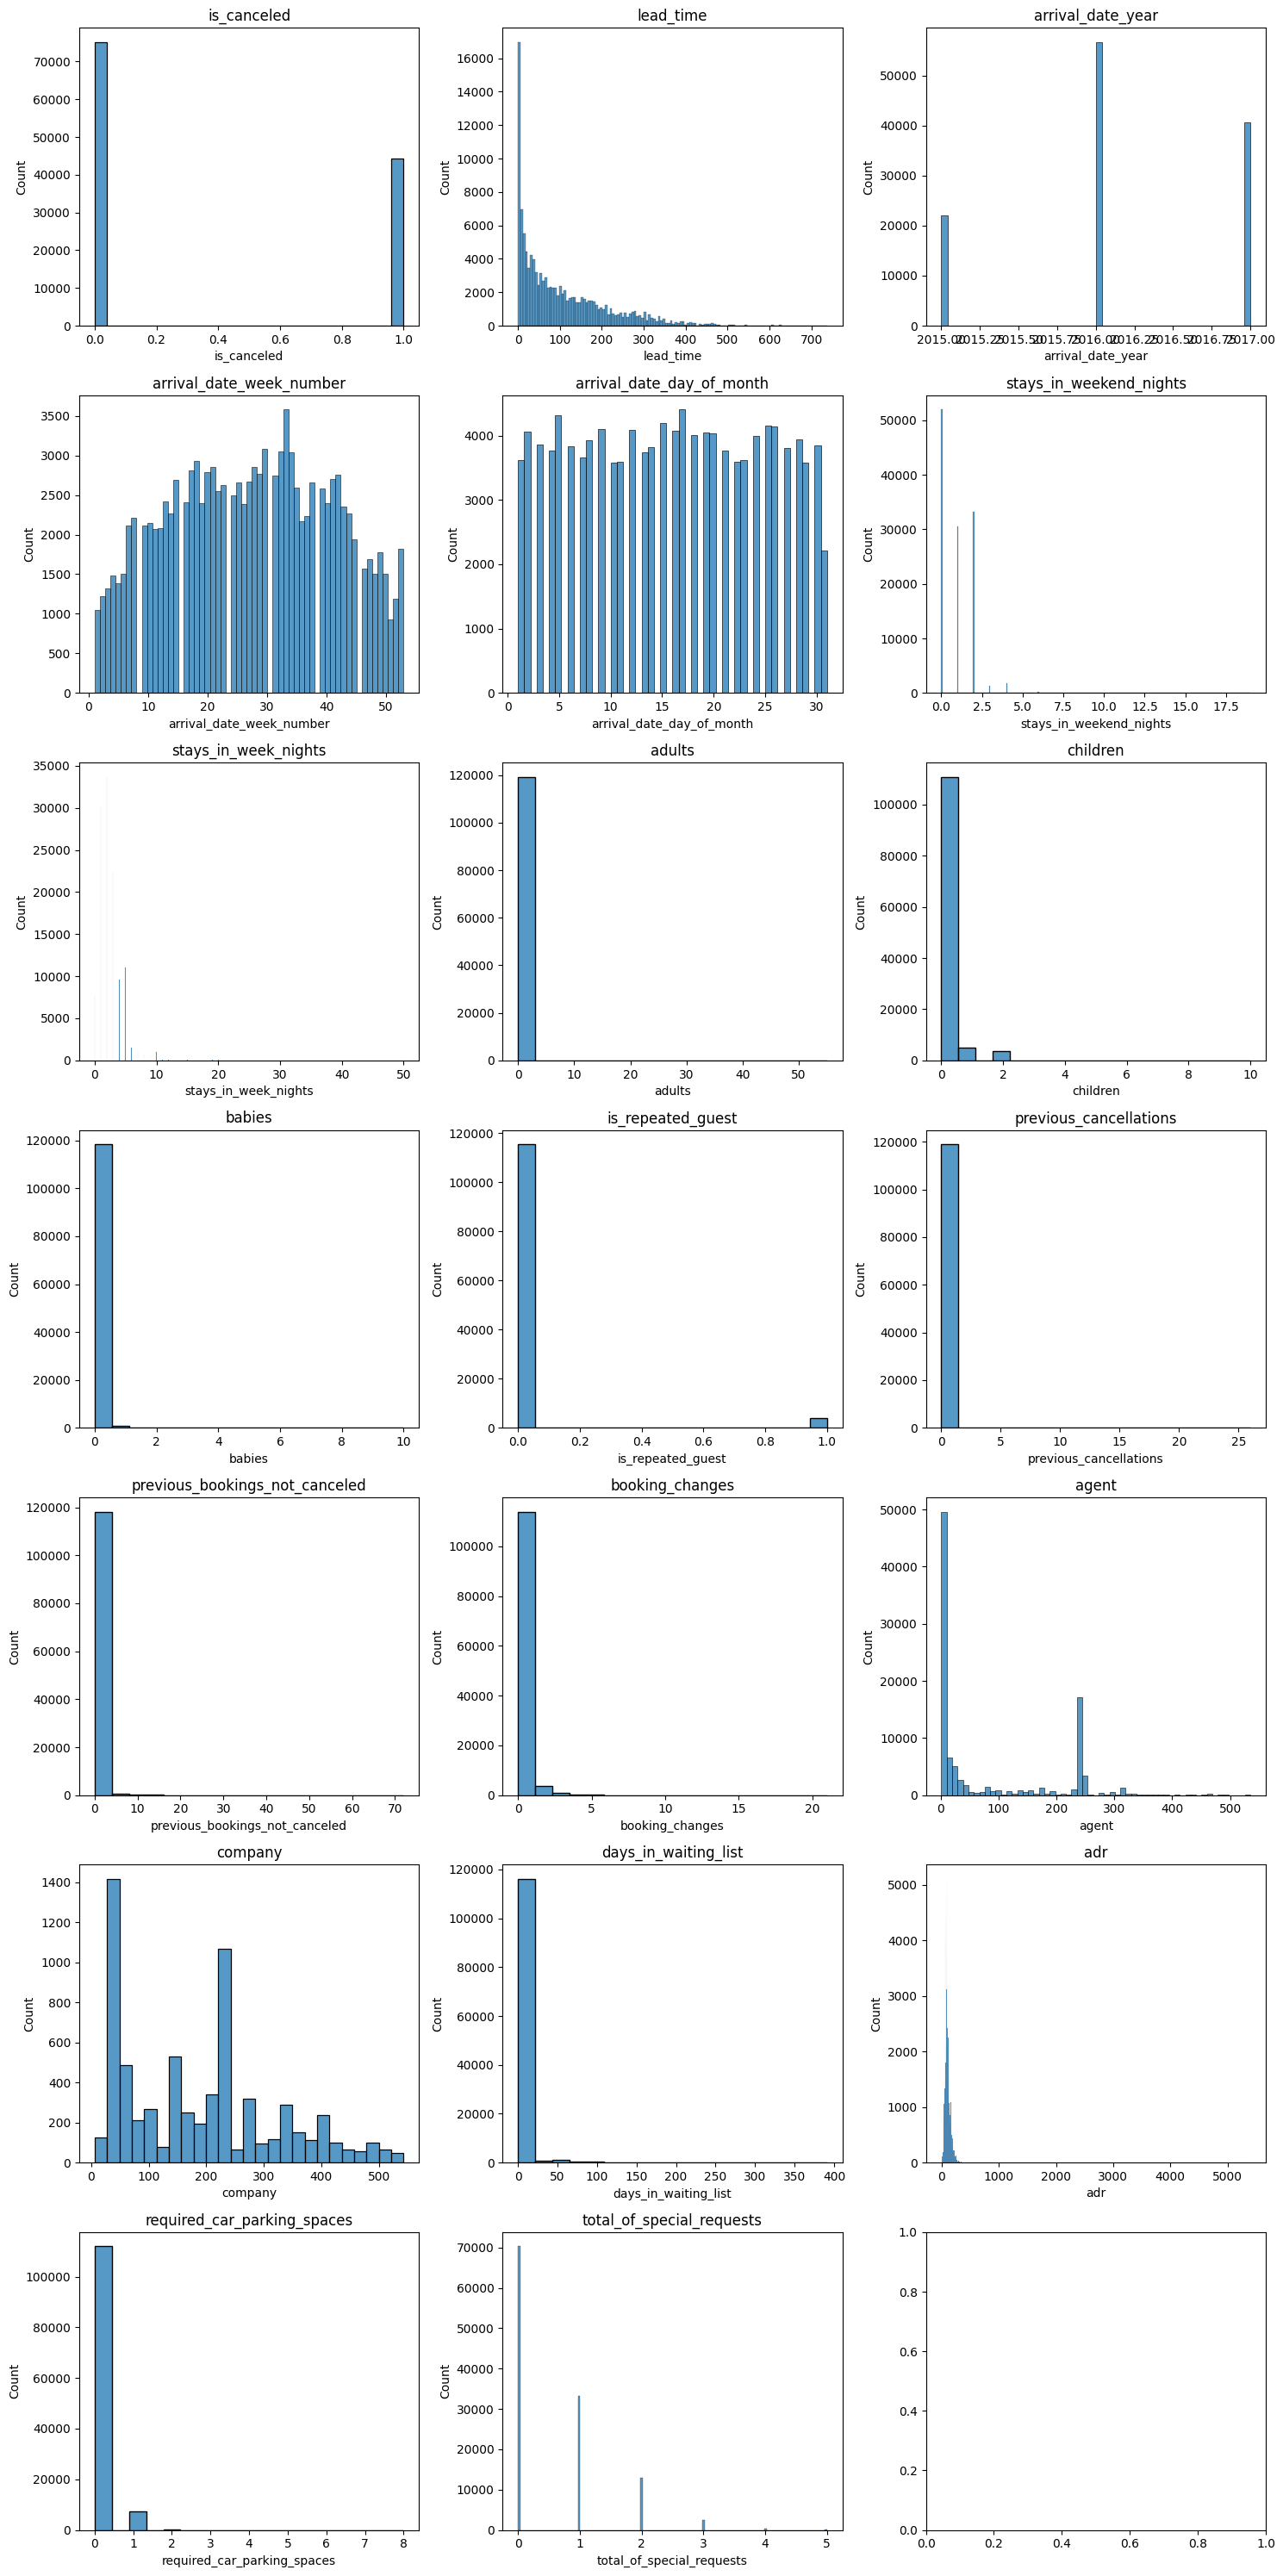

In [11]:
num_cols = df_hotel_demand_bookings.select_dtypes(include=[np.number]).columns

fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(15, 30))

for i, feature in enumerate(num_cols):
    row, col = divmod(i, 3)  
    sns.histplot(x=df_hotel_demand_bookings[feature], ax=axes[row, col])
    axes[row, col].set_title(feature)

plt.tight_layout()
plt.show()

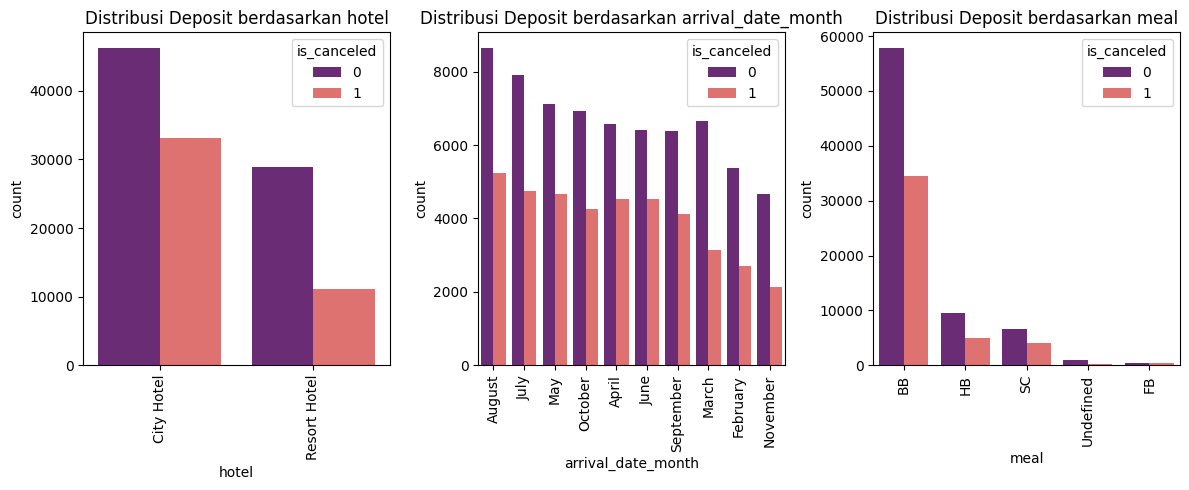

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(12,5))
axes = axes.flatten()

for i, feature in enumerate(df_hotel_demand_bookings[['hotel', 'arrival_date_month', 'meal']].columns.tolist()):
    sns.countplot(x=df_hotel_demand_bookings[feature], hue=df_hotel_demand_bookings['is_canceled'], palette='magma',order=df_hotel_demand_bookings[feature].value_counts().iloc[:10].index, ax=axes[i])
    axes[i].set_title(f'Distribusi Deposit berdasarkan {feature}')
    axes[i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

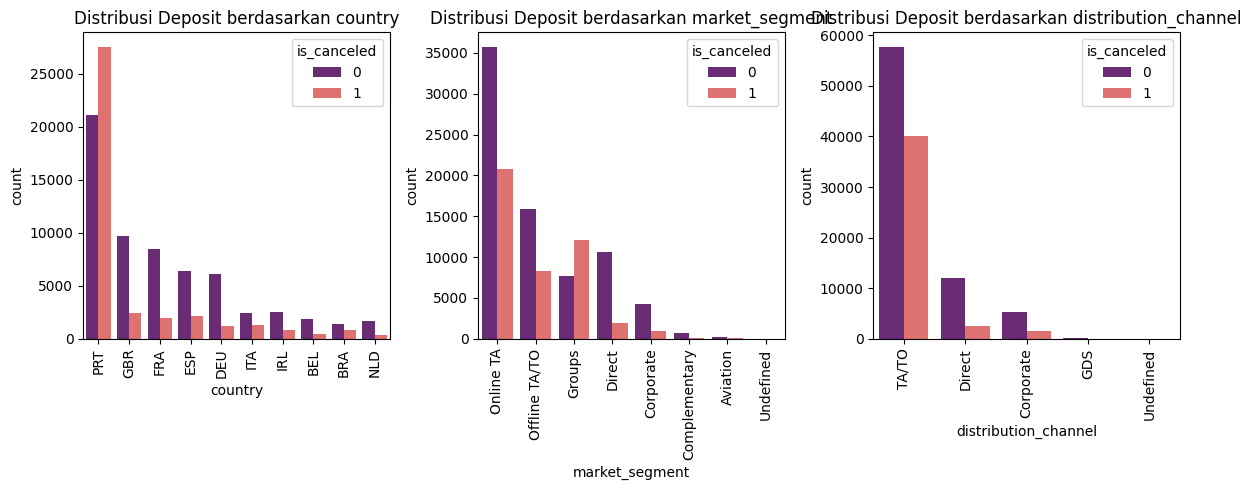

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(12,5))
axes = axes.flatten()

for i, feature in enumerate(df_hotel_demand_bookings[['country', 'market_segment', 'distribution_channel']].columns.tolist()):
    sns.countplot(x=df_hotel_demand_bookings[feature], hue=df_hotel_demand_bookings['is_canceled'], palette='magma', order = df_hotel_demand_bookings[feature].value_counts().iloc[:10].index, ax=axes[i])
    axes[i].set_title(f'Distribusi Deposit berdasarkan {feature}')
    axes[i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

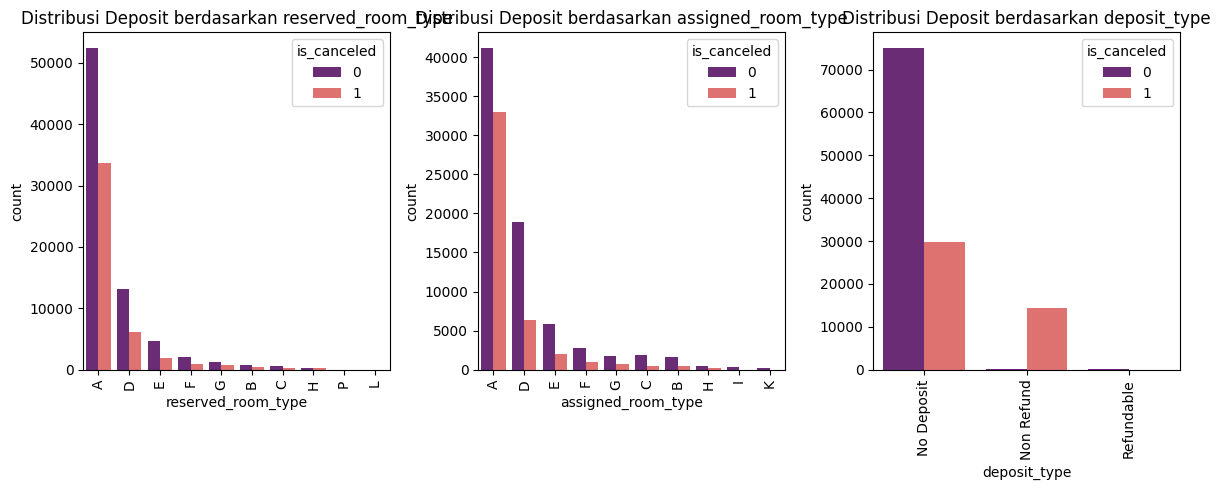

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(12,5))
axes = axes.flatten()

for i, feature in enumerate(df_hotel_demand_bookings[['reserved_room_type', 'assigned_room_type', 'deposit_type']].columns.tolist()):
    sns.countplot(x=df_hotel_demand_bookings[feature], hue=df_hotel_demand_bookings['is_canceled'], palette='magma', order=df_hotel_demand_bookings[feature].value_counts().iloc[:10].index, ax=axes[i])
    axes[i].set_title(f'Distribusi Deposit berdasarkan {feature}')
    axes[i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

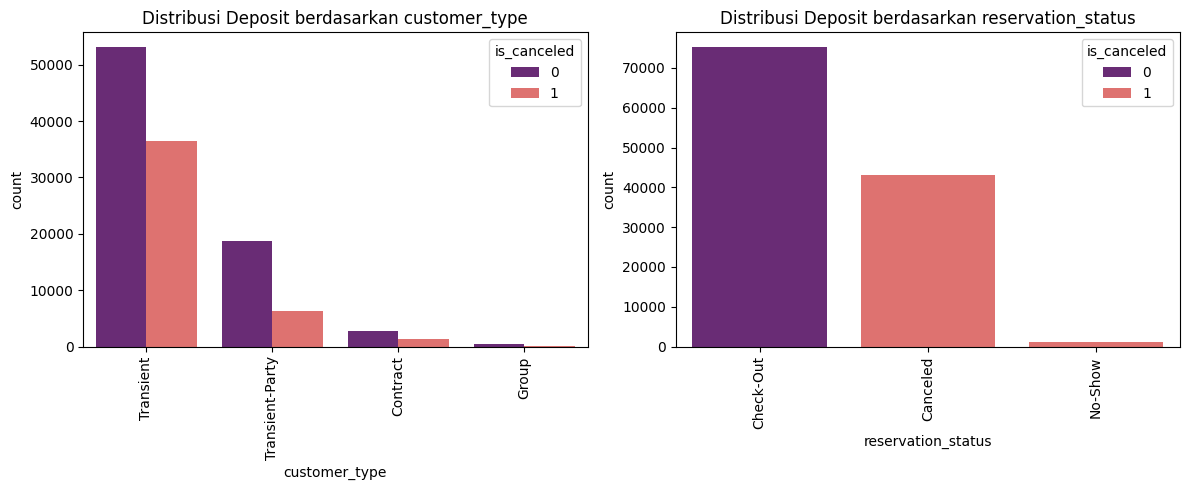

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))
axes = axes.flatten()

for i, feature in enumerate(df_hotel_demand_bookings[['customer_type', 'reservation_status']].columns.tolist()):
    sns.countplot(x=df_hotel_demand_bookings[feature], hue=df_hotel_demand_bookings['is_canceled'], palette='magma', order=df_hotel_demand_bookings[feature].value_counts().iloc[:10].index, ax=axes[i])
    axes[i].set_title(f'Distribusi Deposit berdasarkan {feature}')
    axes[i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

In [16]:
# Melakukan uji korelasi untuk mengetahui hubungan antar kolom numerik

num_cols = df_hotel_demand_bookings.select_dtypes(include=[np.number])

corr_matrix = num_cols.corr(method='pearson')
corr_matrix

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
is_canceled,1.000000,0.293123,0.016660,0.008148,-0.006130,-0.001791,0.024765,0.060017,0.005048,-0.032491,-0.084793,0.110133,-0.057358,-0.144381,-0.083114,-0.020642,0.054186,0.047557,-0.195498,-0.234658
lead_time,0.293123,1.000000,0.040142,0.126871,0.002268,0.085671,0.165799,0.119519,-0.037622,-0.020915,-0.124410,0.086042,-0.073548,0.000149,-0.069741,0.151464,0.170084,-0.063077,-0.116451,-0.095712
arrival_date_year,0.016660,0.040142,1.000000,-0.540561,-0.000221,0.021497,0.030883,0.029635,0.054624,-0.013192,0.010341,-0.119822,0.029218,0.030872,0.063457,0.259095,-0.056497,0.197580,-0.013684,0.108531
arrival_date_week_number,0.008148,0.126871,-0.540561,1.000000,0.066809,0.018208,0.015558,0.025909,0.005518,0.010395,-0.030131,0.035501,-0.020904,0.005508,-0.031201,-0.076760,0.022933,0.075791,0.001920,0.026149
arrival_date_day_of_month,-0.006130,0.002268,-0.000221,0.066809,1.000000,-0.016354,-0.028174,-0.001566,0.014544,-0.000230,-0.006145,-0.027011,-0.000300,0.010613,0.001487,0.044858,0.022728,0.030245,0.008683,0.003062
stays_in_weekend_nights,-0.001791,0.085671,0.021497,0.018208,-0.016354,1.000000,0.498969,0.091871,0.045793,0.018483,-0.087239,-0.012775,-0.042715,0.063281,0.140739,0.066749,-0.054151,0.049342,-0.018554,0.072671
stays_in_week_nights,0.024765,0.165799,0.030883,0.015558,-0.028174,0.498969,1.000000,0.092976,0.044203,0.020191,-0.097245,-0.013992,-0.048743,0.096209,0.182382,0.182211,-0.002020,0.065237,-0.024859,0.068192
adults,0.060017,0.119519,0.029635,0.025909,-0.001566,0.091871,0.092976,1.000000,0.030447,0.018146,-0.146426,-0.006738,-0.107983,-0.051673,-0.035594,0.207793,-0.008283,0.230641,0.014785,0.122884
children,0.005048,-0.037622,0.054624,0.005518,0.014544,0.045793,0.044203,0.030447,1.000000,0.024030,-0.032859,-0.024730,-0.021072,0.048949,0.041066,0.030931,-0.033273,0.324854,0.056253,0.081745
babies,-0.032491,-0.020915,-0.013192,0.010395,-0.000230,0.018483,0.020191,0.018146,0.024030,1.000000,-0.008943,-0.007501,-0.006550,0.083440,0.036184,0.019206,-0.010621,0.029186,0.037383,0.097889


Data Pre - Processing

Data Duplikasi

In [17]:
# Check for duplicated rows
print('Number of duplicated rows = ', df_hotel_demand_bookings.duplicated().sum())

Number of duplicated rows =  31994


In [18]:
df_hotel_demand_bookings.drop_duplicates(inplace=True)

Menangani Missing Value

In [19]:
# Display unique items from each column
def display_unique(df):
  listUniqueItem = []
  for col in df.columns :
      listUniqueItem.append( [col, df[col].nunique(), df[col].isna().sum(), df[col].unique()])

  tableDesc = pd.DataFrame(columns=['Column Name', 'Total of Unique', 'null', 'Unique Sample'],
                      data=listUniqueItem)
  return tableDesc
display_unique(df_hotel_demand_bookings)

,Column Name,Total of Unique,null,Unique Sample
0,hotel,2,0,"[Resort Hotel, City Hotel]"
1,is_canceled,2,0,"[0, 1]"
2,lead_time,479,0,"[342, 737, 7, 13, 14, 0, 9, 85, 75, 23, 35, 68..."
3,arrival_date_year,3,0,"[2015, 2016, 2017]"
4,arrival_date_month,12,0,"[July, August, September, October, November, D..."
5,arrival_date_week_number,53,0,"[27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 3..."
6,arrival_date_day_of_month,31,0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
7,stays_in_weekend_nights,17,0,"[0, 1, 2, 4, 3, 6, 13, 8, 5, 7, 12, 9, 16, 18,..."
8,stays_in_week_nights,35,0,"[0, 1, 2, 3, 4, 5, 10, 11, 8, 6, 7, 15, 9, 12,..."
9,adults,14,0,"[2, 1, 3, 4, 40, 26, 50, 27, 55, 0, 20, 6, 5, 10]"


In [20]:
# Check null values
df_null = pd.DataFrame({'Null Values' : df_hotel_demand_bookings.isnull().sum(),
                        'Percentage Null Values' :
                         (df_hotel_demand_bookings.isna().sum()) / (df_hotel_demand_bookings.shape[0]) * (100)})
df_null = df_null[df_null['Null Values']>0]
df_null.sort_values('Percentage Null Values', ascending=False)

,Null Values,Percentage Null Values
company,82137,93.982562
agent,12193,13.951439
country,452,0.517186
children,4,0.004577


In [21]:
# Menghapus kolom yang tidak diperlukan dalam analisis
# Mengahpus kolom yang memiliki value NaN
# Kolom Company & Agent -> Tidak Relevant untuk analisis, karena tanpa kolom company analisis tetap bisa dilakukan dan juga kolom yang paling banyak missing value

df_hotel_demand_bookings.drop(['company', 'agent'], axis=1, inplace=True)
df_hotel_demand_bookings.dropna(inplace=True)

In [22]:
# Melihat kembali apakah masih ada data yang hilang

df_hotel_demand_bookings.isnull().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests   

In [23]:
# Menghapus baris yang memiliki nilai 0 pada kolom adults
# Karena tidak mungkin ada pemesanan hotel tanpa orang dewasa

df_hotel_demand_bookings = df_hotel_demand_bookings[df_hotel_demand_bookings['adults'] != 0]

Data Outlier

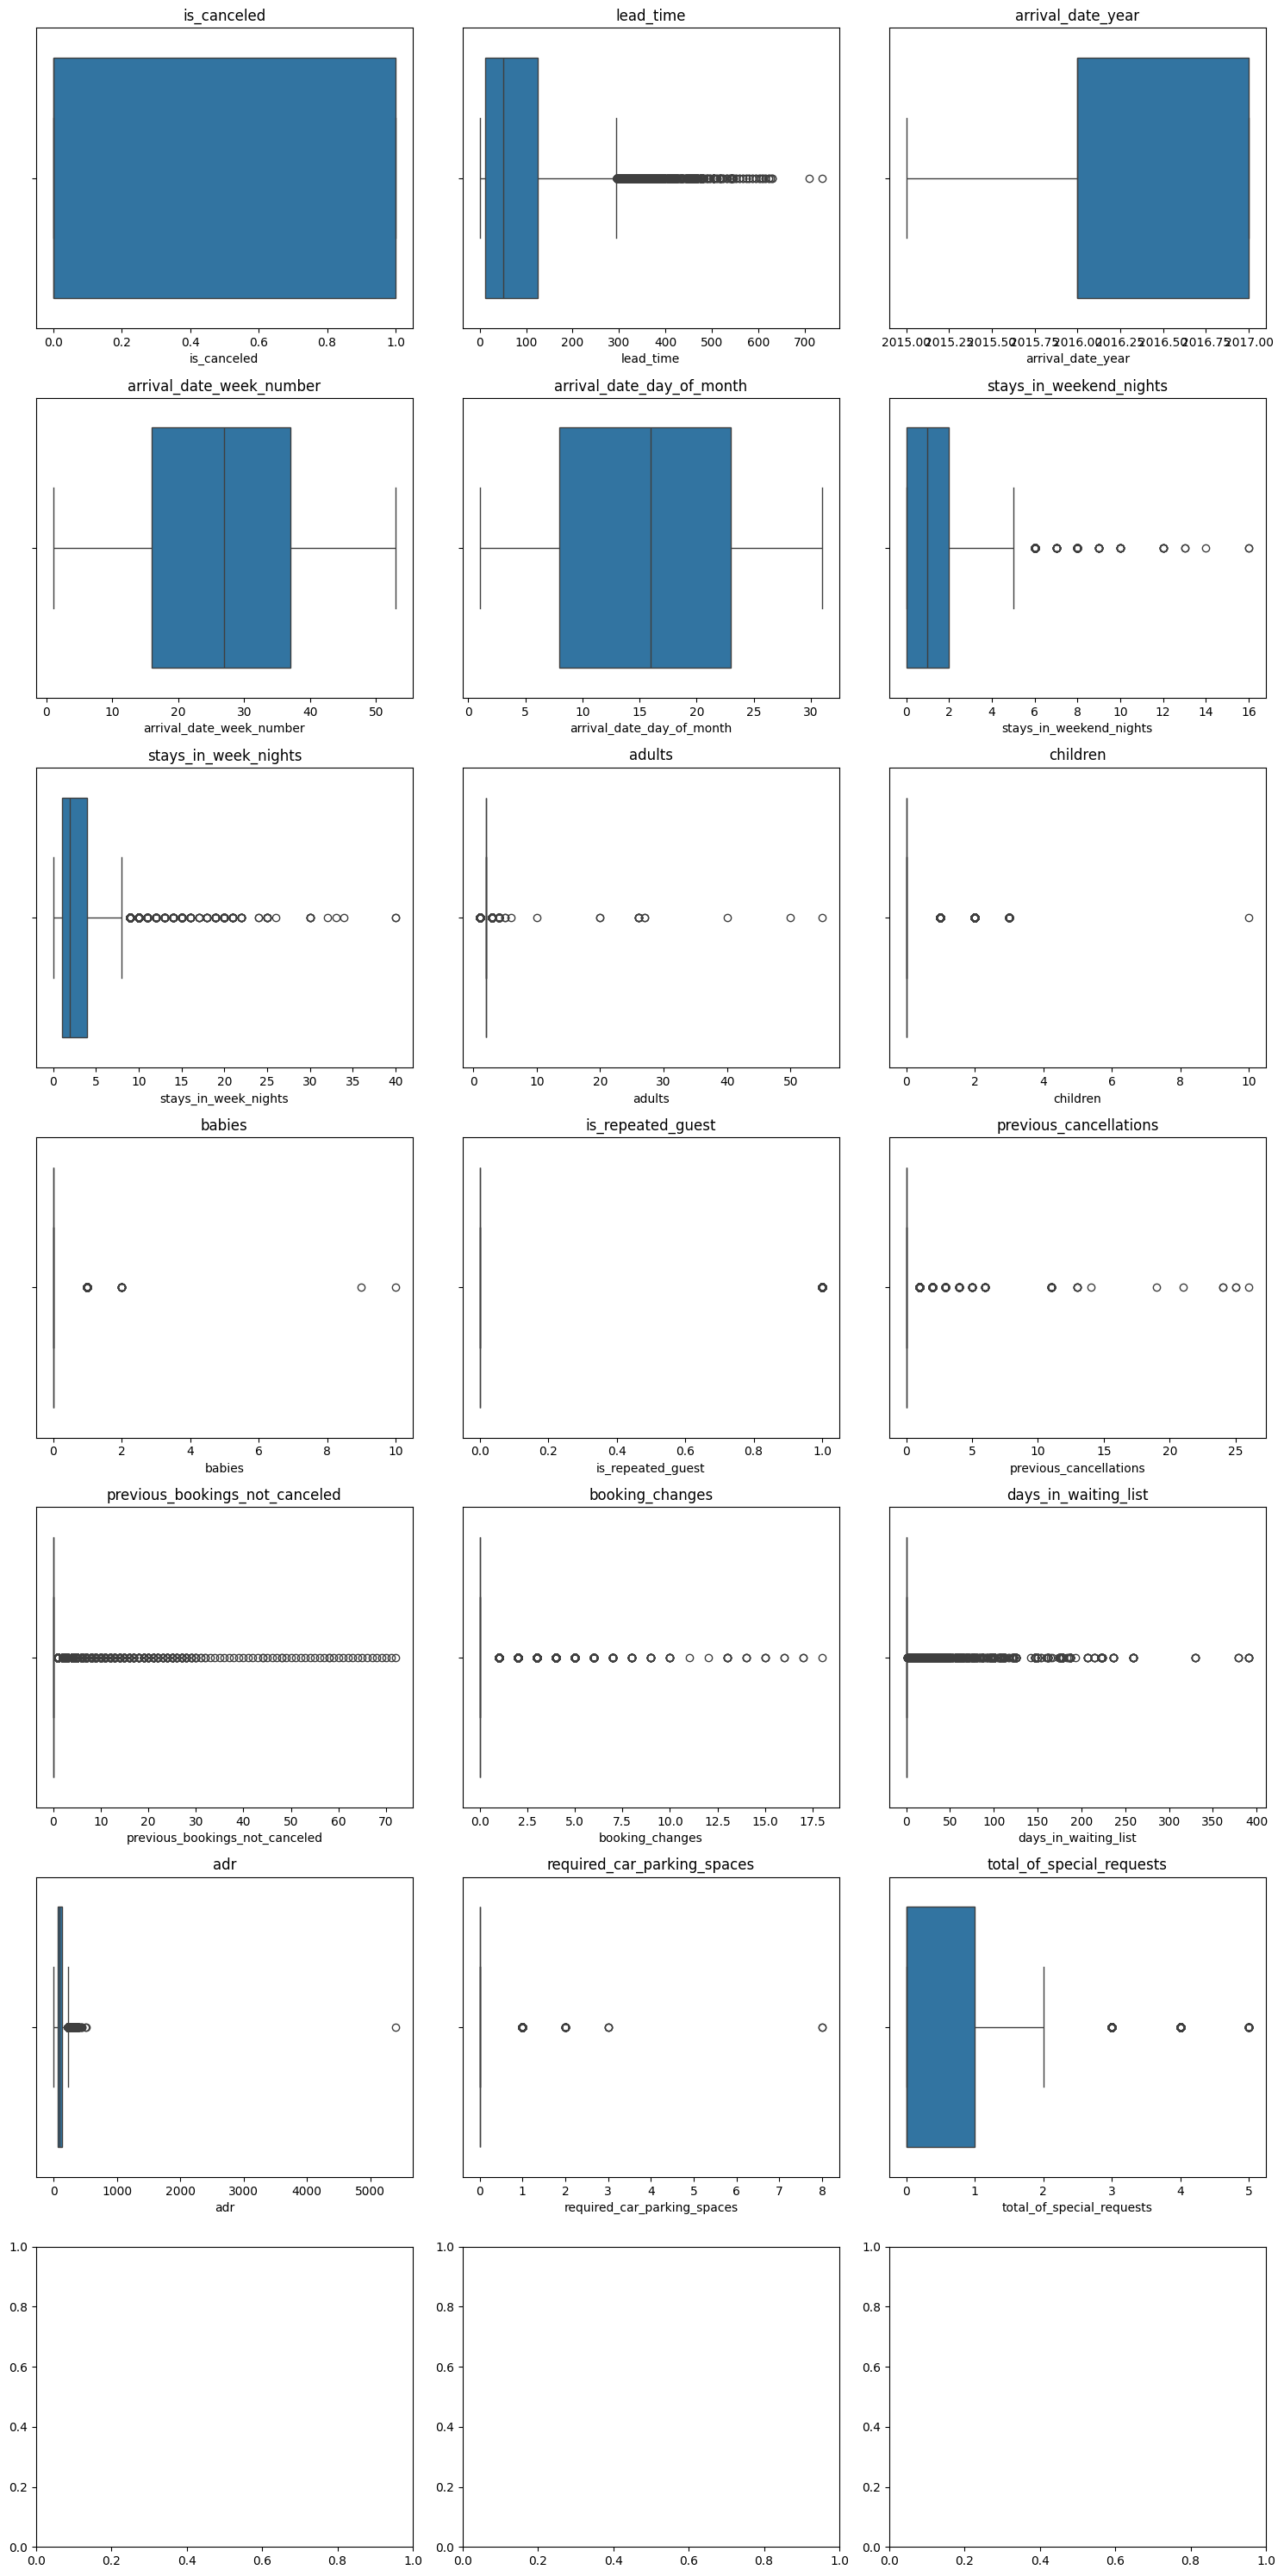

In [24]:
num_cols = df_hotel_demand_bookings.select_dtypes(include=[np.number]).columns

fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(15, 30))

for i, feature in enumerate(num_cols):
    row, col = divmod(i, 3)  
    sns.boxplot(x=df_hotel_demand_bookings[feature], ax=axes[row, col])
    axes[row, col].set_title(feature)

plt.tight_layout()
plt.show()

In [25]:
df_hotel_demand_bookings

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,C,3,No Deposit,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,C,4,No Deposit,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,C,0,No Deposit,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,A,0,No Deposit,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,A,0,No Deposit,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,A,0,No Deposit,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,E,0,No Deposit,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,D,0,No Deposit,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,A,0,No Deposit,0,Transient,104.40,0,0,Check-Out,2017-09-07


Data Analysis

Uji Distribusi Normal dengan Uji Frequentist

In [26]:
# Memilih hanya kolom numerik
num_cols = df_hotel_demand_bookings.select_dtypes(include=[np.number]).columns

# Fungsi untuk Kolmogorov Smirnov Test untuk setiap kolom numerik
def ks_test(series):
    data = series.dropna()
    mu, sigma = data.mean(), data.std(ddof=0)
    # K‑S terhadap N(mu, sigma)
    stat, p = kstest(data, "norm", args=(mu, sigma))
    return stat, p

# Fungsi untuk D'Agostino and Pearson Test untuk setiap kolom numerik

def dagostino_pearson(series):
    data = series.dropna()
    # scipy normaltest (omnibus) ⇒ p kecil → tolak normalitas
    stat, p = normaltest(data)
    return stat, p

rows = []
for col in num_cols:
    ks_stat,  ks_p  = ks_test(df_hotel_demand_bookings[col])
    dp_stat, dp_p   = dagostino_pearson(df_hotel_demand_bookings[col])
    rows.append({
        "column": col,
        "KS_stat": ks_stat,        "KS_pvalue": ks_p,
        "DP_stat": dp_stat,        "DP_pvalue": dp_p,
        "n": df_hotel_demand_bookings[col].notna().sum()
    })

result = pd.DataFrame(rows).set_index("column")
result = result.sort_values("KS_pvalue", ascending=True)

pd.set_option("display.float_format", "{:.3e}".format)
print("Normality tests (Kolmogorov–Smirnov & D'Agostino‑Pearson):")
display(result)

Normality tests (Kolmogorov–Smirnov & D'Agostino‑Pearson):


,KS_stat,KS_pvalue,DP_stat,DP_pvalue,n
column,,,,,
is_canceled,4.555e-01,0.000e+00,2.976e+04,0.000e+00,86560
adr,7.380e-02,0.000e+00,1.509e+05,0.000e+00,86560
days_in_waiting_list,5.200e-01,0.000e+00,1.861e+05,0.000e+00,86560
booking_changes,4.661e-01,0.000e+00,9.066e+04,0.000e+00,86560
previous_bookings_not_canceled,5.027e-01,0.000e+00,1.926e+05,0.000e+00,86560
previous_cancellations,5.135e-01,0.000e+00,2.367e+05,0.000e+00,86560
is_repeated_guest,5.408e-01,0.000e+00,7.989e+04,0.000e+00,86560
babies,5.275e-01,0.000e+00,1.966e+05,0.000e+00,86560
children,5.243e-01,0.000e+00,6.280e+04,0.000e+00,86560


Dari hasil test uji distribusi normal menggunakan Kolmogrov Smirnov dan D'Agostino and Pearson, kita bisa melihat pada kolom KS_pvalue dan DP_pvalue untuk setiap kolom numerik, p-value <= 0.05 yang artinya datanya tidak terdistribusi normal

Tetapi, karena dataset yang kita miliki sangat banyak, kita bisa asumsikan data kita terdisitribusi normal

Menentukan Kolum Numerik dan Kategorikal

In [27]:
num_cols_names = [
    'lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights',
    'adults', 'children', 'babies', 'is_repeated_guest',
    'previous_cancellations', 'previous_bookings_not_canceled',
    'booking_changes', 'days_in_waiting_list', 'adr',
    'required_car_parking_spaces', 'total_of_special_requests'
]

df_num = df_hotel_demand_bookings[num_cols_names + ['is_canceled']]

cat_cols_names = [
    'hotel', 'arrival_date_month', 'meal', 'market_segment',
    'distribution_channel', 'reserved_room_type', 'assigned_room_type',
    'deposit_type', 'customer_type'
]

df_cat = df_hotel_demand_bookings[cat_cols_names + ['is_canceled']]

In [28]:
print(type(col),col)

<class 'str'> total_of_special_requests


Uji Normalitas Data Numerik Menggunakan D'Agostino Test

In [29]:
normality_results = []

for col in num_cols_names:
    data = df_num[col].sample(5000, random_state=42) if df_num.shape[0] > 5000 else df_num[col]
    stat, pval = normaltest(data)
    normal = pval > 0.05
    normality_results.append((col, pval, normal))
    print(f"{col:<35} | p-value: {pval:.4f} | Normal: {'Yes' if normal else 'No'}")

lead_time                           | p-value: 0.0000 | Normal: No
stays_in_weekend_nights             | p-value: 0.0000 | Normal: No
stays_in_week_nights                | p-value: 0.0000 | Normal: No
adults                              | p-value: 0.0000 | Normal: No
children                            | p-value: 0.0000 | Normal: No
babies                              | p-value: 0.0000 | Normal: No
is_repeated_guest                   | p-value: 0.0000 | Normal: No
previous_cancellations              | p-value: 0.0000 | Normal: No
previous_bookings_not_canceled      | p-value: 0.0000 | Normal: No
booking_changes                     | p-value: 0.0000 | Normal: No
days_in_waiting_list                | p-value: 0.0000 | Normal: No
adr                                 | p-value: 0.0000 | Normal: No
required_car_parking_spaces         | p-value: 0.0000 | Normal: No
total_of_special_requests           | p-value: 0.0000 | Normal: No


Uji Statistik Numerik

In [30]:
print("\nUji Statistik Numerik berdasarkan Normalitas:\n")

for col, _, is_normal in normality_results:
    data_0 = df_num[df_num['is_canceled'] == 0][col]
    data_1 = df_num[df_num['is_canceled'] == 1][col]

    if is_normal:
        stat, pval = ttest_ind(data_0, data_1, equal_var=False)
        test_name = 'T-Test'
    else:
        stat, pval = mannwhitneyu(data_0, data_1, alternative='two-sided')
        test_name = 'Mann-Whitney U'

    mean_0 = data_0.mean()
    mean_1 = data_1.mean()

    print(f"{col:<35} | Test: {test_name:<15} | p-value: {pval:.4f} | Mean[0]: {mean_0:.2f} | Mean[1]: {mean_1:.2f} | Signifikan: {'Yes' if pval < 0.05 else 'No'}")



Uji Statistik Numerik berdasarkan Normalitas:

lead_time                           | Test: Mann-Whitney U  | p-value: 0.0000 | Mean[0]: 70.43 | Mean[1]: 105.67 | Signifikan: Yes
stays_in_weekend_nights             | Test: Mann-Whitney U  | p-value: 0.0000 | Mean[0]: 0.97 | Mean[1]: 1.11 | Signifikan: Yes
stays_in_week_nights                | Test: Mann-Whitney U  | p-value: 0.0000 | Mean[0]: 2.52 | Mean[1]: 2.90 | Signifikan: Yes
adults                              | Test: Mann-Whitney U  | p-value: 0.0000 | Mean[0]: 1.86 | Mean[1]: 1.97 | Signifikan: Yes
children                            | Test: Mann-Whitney U  | p-value: 0.0000 | Mean[0]: 0.12 | Mean[1]: 0.18 | Signifikan: Yes
babies                              | Test: Mann-Whitney U  | p-value: 0.0000 | Mean[0]: 0.01 | Mean[1]: 0.01 | Signifikan: Yes
is_repeated_guest                   | Test: Mann-Whitney U  | p-value: 0.0000 | Mean[0]: 0.05 | Mean[1]: 0.01 | Signifikan: Yes
previous_cancellations              | Test: Mann-Whit

Uji Statistik Kategorikal

In [31]:
for col in cat_cols_names:
    table = pd.crosstab(df_cat[col], df_cat['is_canceled'])
    if table.shape[0] < 2 or table.shape[1] != 2:
        continue
    chi2, pval, dof, expected = chi2_contingency(table)
    print(f"{col:<25} | p-value: {pval:.4f} | Signifikan: {'Yes' if pval < 0.05 else 'No'}")

hotel                     | p-value: 0.0000 | Signifikan: Yes
arrival_date_month        | p-value: 0.0000 | Signifikan: Yes
meal                      | p-value: 0.0000 | Signifikan: Yes
market_segment            | p-value: 0.0000 | Signifikan: Yes
distribution_channel      | p-value: 0.0000 | Signifikan: Yes
reserved_room_type        | p-value: 0.0000 | Signifikan: Yes
assigned_room_type        | p-value: 0.0000 | Signifikan: Yes
deposit_type              | p-value: 0.0000 | Signifikan: Yes
customer_type             | p-value: 0.0000 | Signifikan: Yes


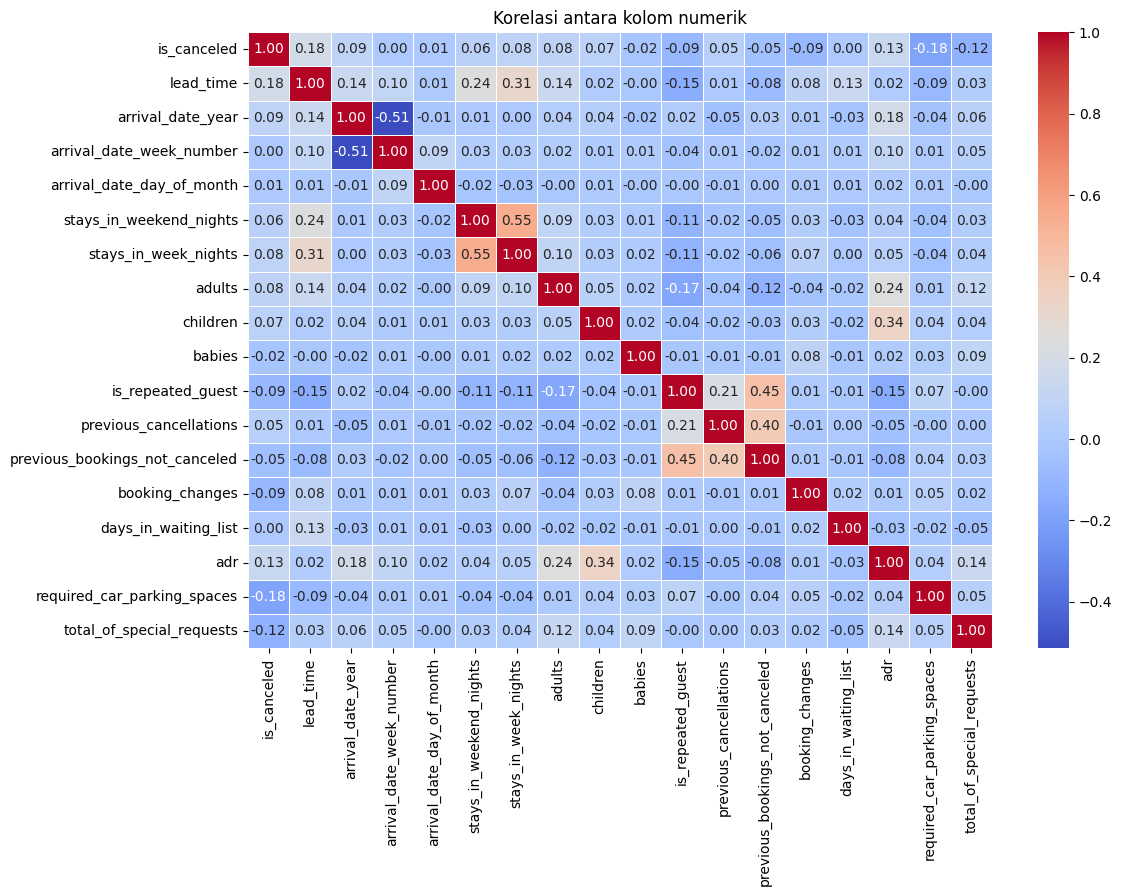

In [32]:
# Melihat korelasi antar kolom numerik

num_cols = df_hotel_demand_bookings.select_dtypes(include=[np.number])
correlation_matrix = num_cols.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Korelasi antara kolom numerik")
plt.show()

In [33]:
# Melihat pasangan kolom yang memiliki korelasi (positif maupun negatif) tertinggi

corr_pairs = (
    correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
         .stack()
         .reset_index()
         .rename(columns={"level_0":"Variable 1","level_1":"Variable 2",0:"r value"})
         .sort_values("r value", ascending=False)
)


print("\nPasangan kolom dengan korelasi tertinggi:")

df_corr_pairs = pd.DataFrame(corr_pairs)
display(df_corr_pairs)



Pasangan kolom dengan korelasi tertinggi:


,Variable 1,Variable 2,r value
75,stays_in_weekend_nights,stays_in_week_nights,5.466e-01
126,is_repeated_guest,previous_bookings_not_canceled,4.501e-01
132,previous_cancellations,previous_bookings_not_canceled,3.956e-01
114,children,adr,3.394e-01
21,lead_time,stays_in_week_nights,3.127e-01
...,...,...,...
25,lead_time,is_repeated_guest,-1.468e-01
129,is_repeated_guest,adr,-1.511e-01
100,adults,is_repeated_guest,-1.712e-01
15,is_canceled,required_car_parking_spaces,-1.841e-01


In [34]:
# Melihat korelasi antara kolom is_canceled dengan kolom numerik lainnya
# Diurutkan dari yang paling besar korelasinya

target = "is_canceled"
corr_to_target = (
    correlation_matrix[target]
    .drop(target)
    .sort_values(ascending=False)
)

print("\nKorelasi kolom lain terhadap:", target)
display(corr_to_target)


Korelasi kolom lain terhadap: is_canceled


lead_time                         1.830e-01
adr                               1.261e-01
arrival_date_year                 8.760e-02
stays_in_week_nights              8.390e-02
adults                            8.108e-02
children                          6.616e-02
stays_in_weekend_nights           6.044e-02
previous_cancellations            5.101e-02
arrival_date_day_of_month         5.471e-03
days_in_waiting_list              4.588e-03
arrival_date_week_number          1.124e-03
babies                           -2.073e-02
previous_bookings_not_canceled   -5.060e-02
is_repeated_guest                -8.928e-02
booking_changes                  -9.363e-02
total_of_special_requests        -1.224e-01
required_car_parking_spaces      -1.841e-01
Name: is_canceled, dtype: float64

TARGET FEATURE DISTRIBUTION

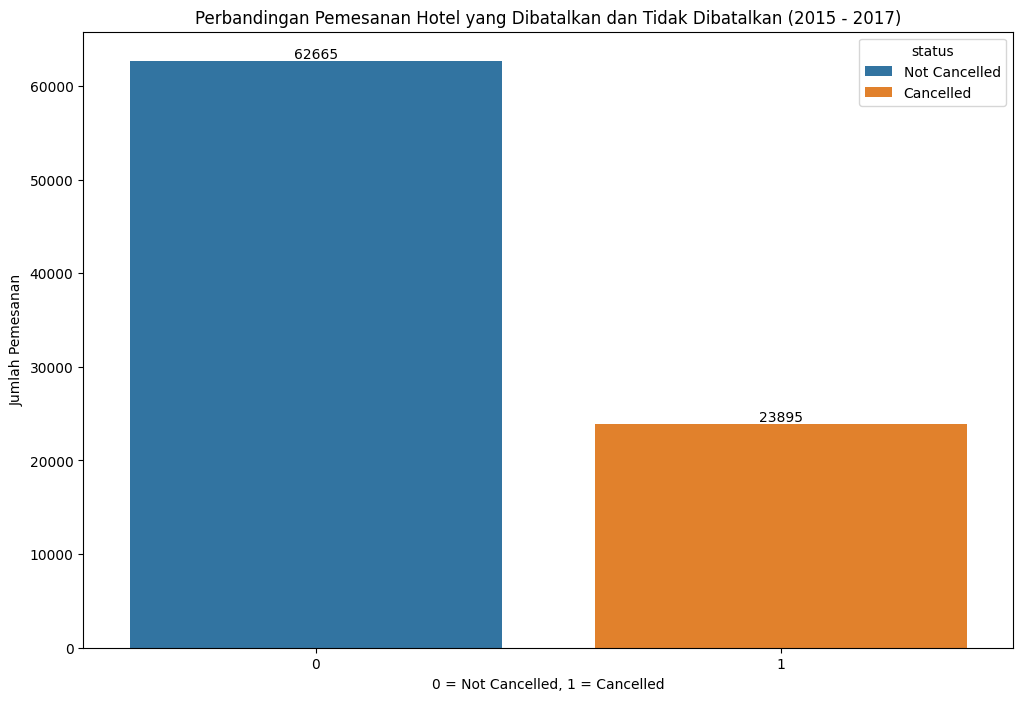

In [35]:
# Melihat perbandingan pemesanan hotel yang dibatalkan dan tidak dibatalkan

plt.figure(figsize=(12,8))

counts = (
    df_hotel_demand_bookings.groupby(['is_canceled'])
      .size()
      .reset_index(name='count')
)

counts['status'] = counts['is_canceled'].map({0: 'Not Cancelled', 1: 'Cancelled'})

cancelation_rate_barplot = sns.barplot(
    data=counts,
    x='is_canceled',
    y='count',
    hue='status'
)

for container in cancelation_rate_barplot.containers:
    cancelation_rate_barplot.bar_label(container, fmt='%.0f')

plt.title('Perbandingan Pemesanan Hotel yang Dibatalkan dan Tidak Dibatalkan (2015 - 2017)')
plt.xlabel('0 = Not Cancelled, 1 = Cancelled')
plt.ylabel('Jumlah Pemesanan')
plt.show()

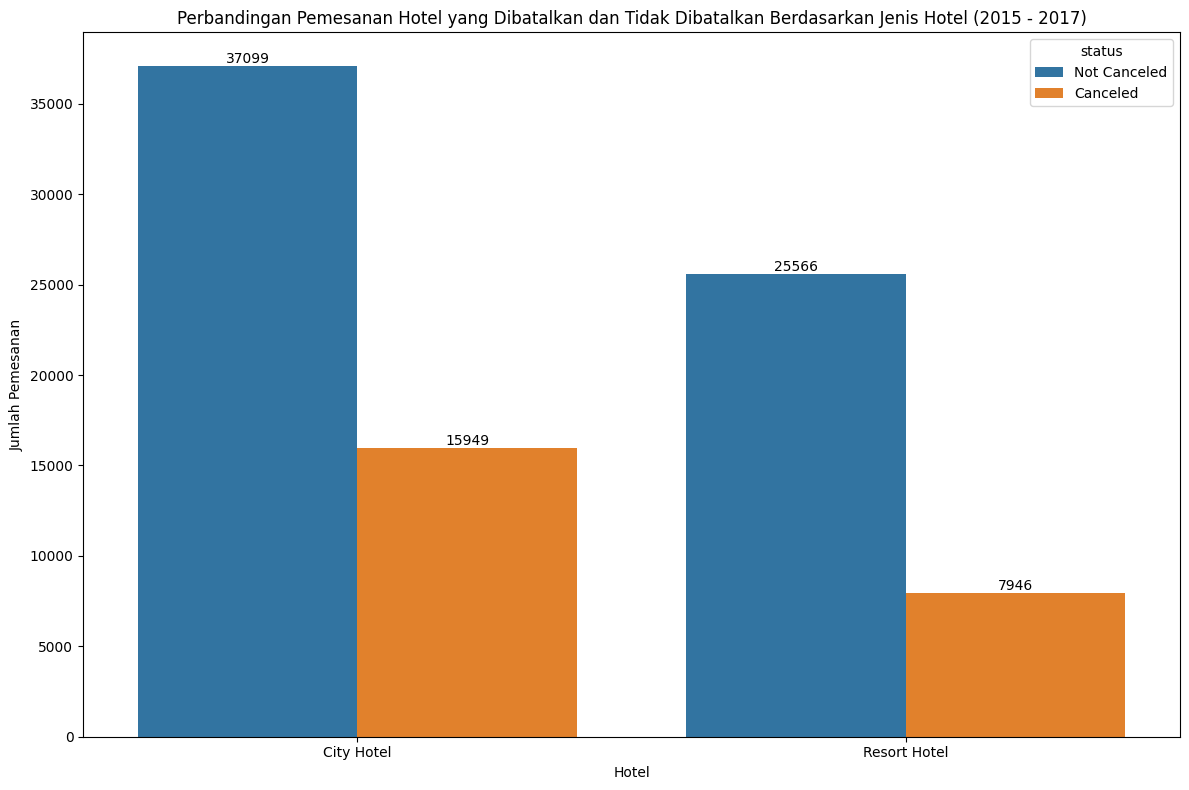

In [36]:
# Melihat jumlah pemesanan hotel yang dibatalkan dan tidak dibatalkan berdasarkan jenis hotel

plt.figure(figsize=(12, 8))

counts = (
    df_hotel_demand_bookings.groupby(['hotel', 'is_canceled'])
      .size()
      .reset_index(name='count')
)

counts['status'] = counts['is_canceled'].map({0: 'Not Canceled', 1: 'Canceled'})

cancelation_rate_by_hotel_barplot = sns.barplot(
    data=counts, x='hotel', y='count', hue='status'
  )

for container in cancelation_rate_by_hotel_barplot.containers:
    cancelation_rate_by_hotel_barplot.bar_label(container, fmt='%.0f')

plt.title('Perbandingan Pemesanan Hotel yang Dibatalkan dan Tidak Dibatalkan Berdasarkan Jenis Hotel (2015 - 2017)')
plt.ylabel('Jumlah Pemesanan')
plt.xlabel('Hotel')
plt.tight_layout()
plt.show()

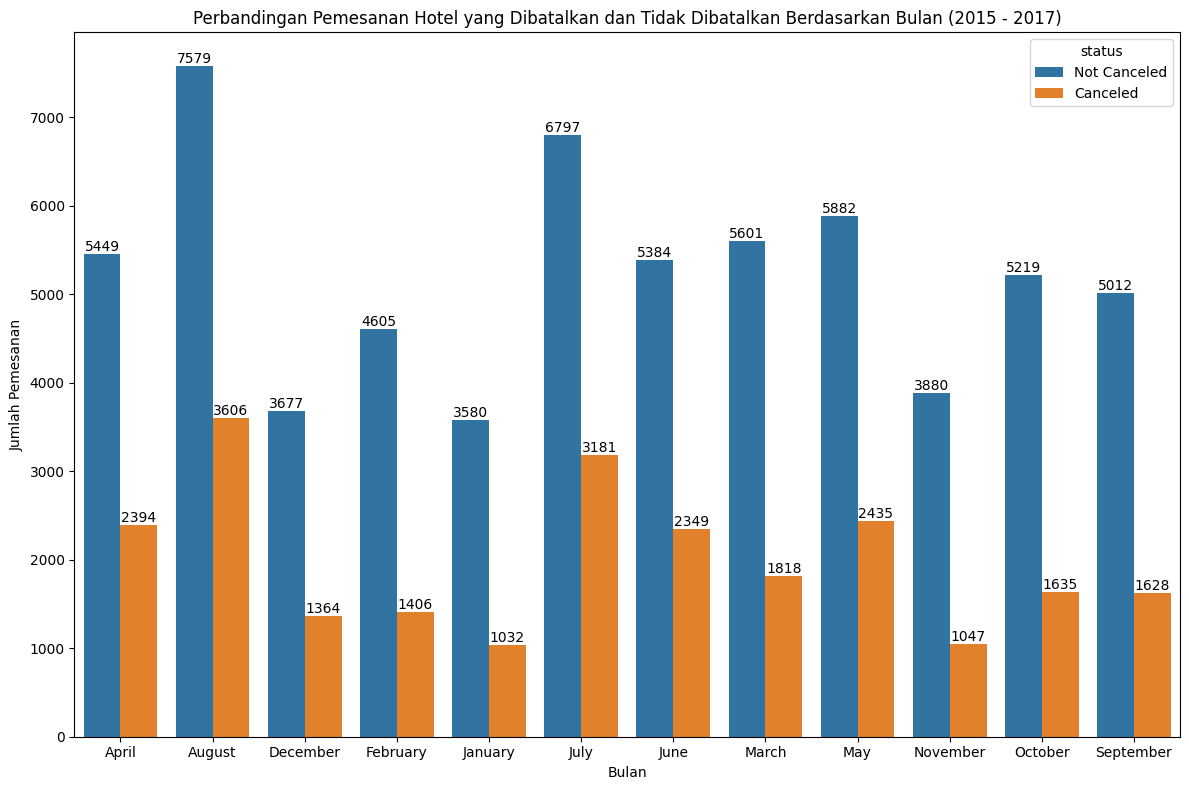

In [37]:
# Melihat perbandingan pemesanan hotel yang dibatalkan dan tidak dibatalkan berdasarkan bulan

plt.figure(figsize=(12, 8))

counts = (
    df_hotel_demand_bookings.groupby(['arrival_date_month', 'is_canceled'])
      .size()
      .reset_index(name='count')
)

counts['status'] = counts['is_canceled'].map({0: 'Not Canceled', 1: 'Canceled'})

cancelation_rate_per_month_barplot = sns.barplot(
    data=counts, x='arrival_date_month', y='count', hue='status'
  )

for container in cancelation_rate_per_month_barplot.containers:
    cancelation_rate_per_month_barplot.bar_label(container, fmt='%.0f')

plt.title('Perbandingan Pemesanan Hotel yang Dibatalkan dan Tidak Dibatalkan Berdasarkan Bulan (2015 - 2017)')
plt.ylabel('Jumlah Pemesanan')
plt.xlabel('Bulan')
plt.tight_layout()
plt.show()

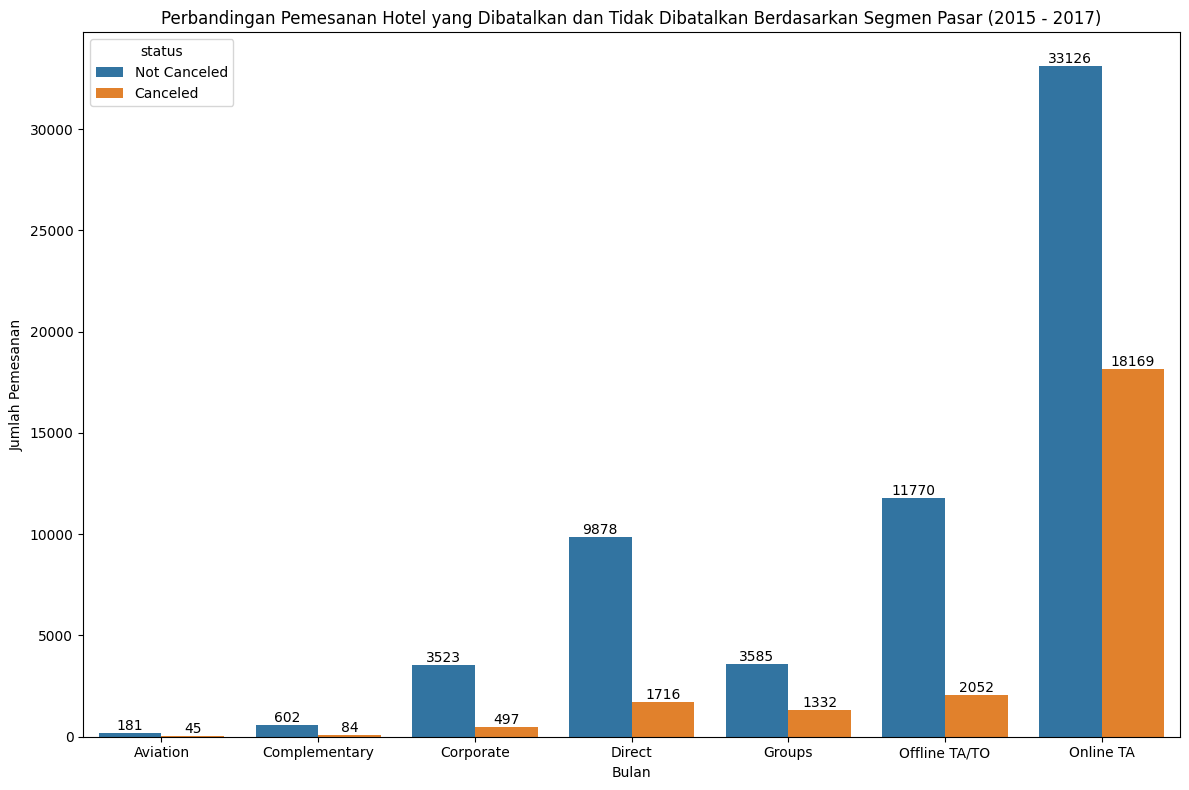

In [38]:
# Melihat perbandingan pemesanan hotel yang dibatalkan dan tidak dibatalkan berdasarkan segmen pasar

plt.figure(figsize=(12, 8))

counts = (
    df_hotel_demand_bookings.groupby(['market_segment', 'is_canceled'])
      .size()
      .reset_index(name='count')
)

counts['status'] = counts['is_canceled'].map({0: 'Not Canceled', 1: 'Canceled'})

cancelation_rate_by_market_segment_barplot = sns.barplot(
    data=counts, x='market_segment', y='count', hue='status'
  )

for container in cancelation_rate_by_market_segment_barplot.containers:
    cancelation_rate_by_market_segment_barplot.bar_label(container, fmt='%.0f')

plt.title('Perbandingan Pemesanan Hotel yang Dibatalkan dan Tidak Dibatalkan Berdasarkan Segmen Pasar (2015 - 2017)')
plt.ylabel('Jumlah Pemesanan')
plt.xlabel('Bulan')
plt.tight_layout()
plt.show()

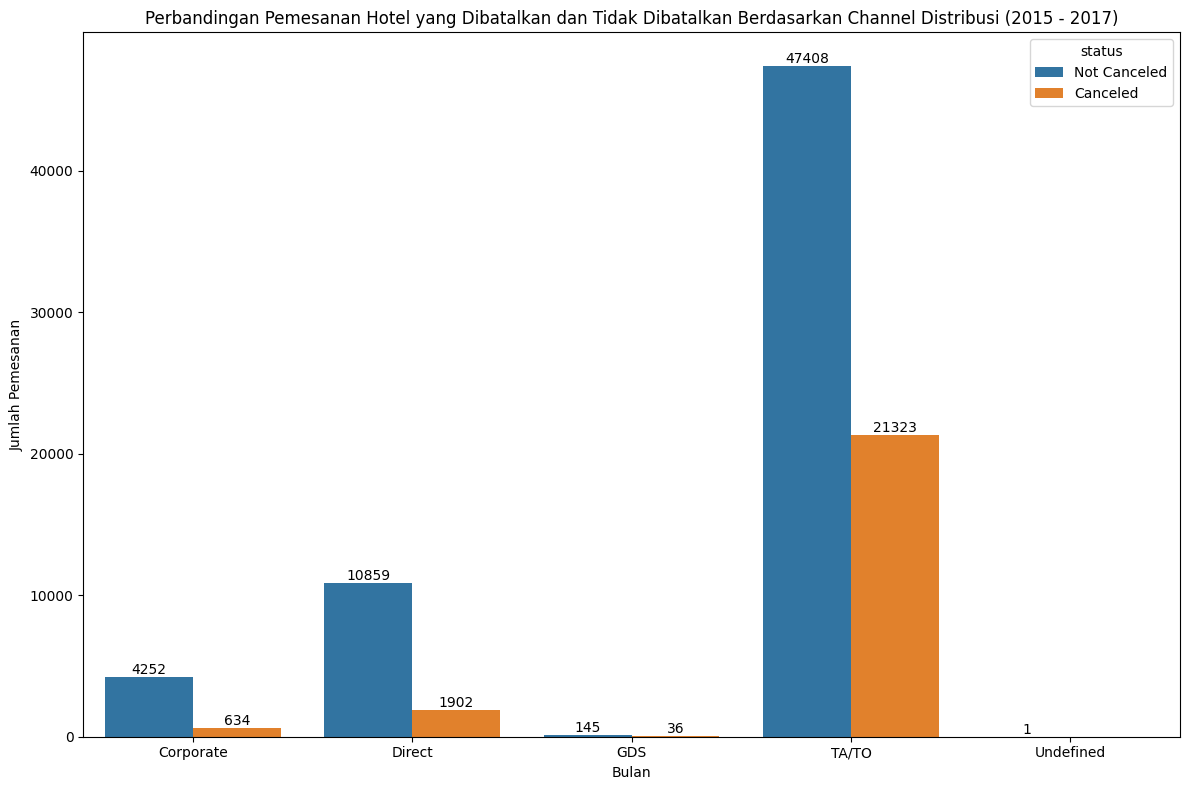

In [39]:
# Melihat perbandingan pemesanan hotel yang dibatalkan dan tidak dibatalkan berdasarkan distribution channel

plt.figure(figsize=(12, 8))

counts = (
    df_hotel_demand_bookings.groupby(['distribution_channel', 'is_canceled'])
      .size()
      .reset_index(name='count')
)

counts['status'] = counts['is_canceled'].map({0: 'Not Canceled', 1: 'Canceled'})

cancelation_rate_by_distribution_channel_barplot = sns.barplot(
    data=counts, x='distribution_channel', y='count', hue='status'
  )

for container in cancelation_rate_by_distribution_channel_barplot.containers:
    cancelation_rate_by_distribution_channel_barplot.bar_label(container, fmt='%.0f')

plt.title('Perbandingan Pemesanan Hotel yang Dibatalkan dan Tidak Dibatalkan Berdasarkan Channel Distribusi (2015 - 2017)')
plt.ylabel('Jumlah Pemesanan')
plt.xlabel('Bulan')
plt.tight_layout()
plt.show()

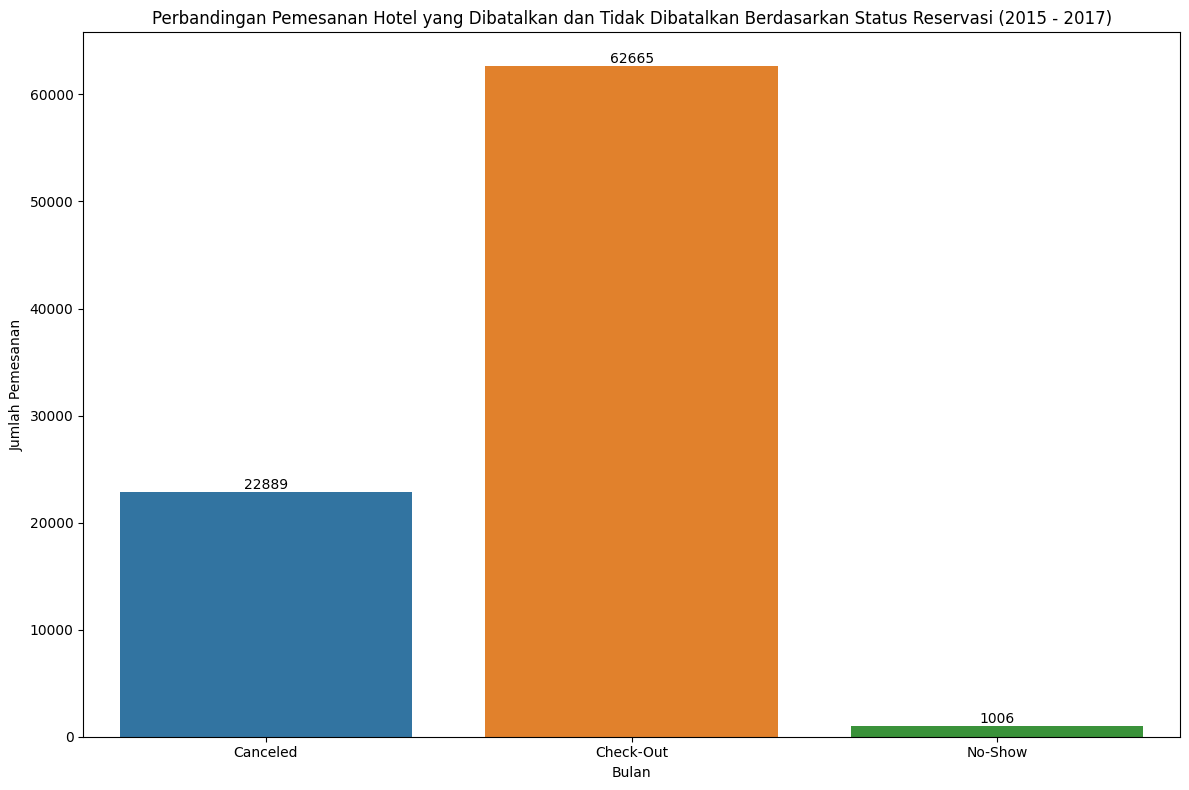

In [40]:
# Melihat perbandingan pemesanan hotel yang dibatalkan dan tidak dibatalkan berdasarkan status reservasi

plt.figure(figsize=(12, 8))

counts = (
    df_hotel_demand_bookings.groupby(['reservation_status', 'is_canceled'])
      .size()
      .reset_index(name='count')
)

cancelation_rate_by_reservation_status_barplot = sns.barplot(
    data=counts, x='reservation_status', y='count', hue='reservation_status'
  )

for container in cancelation_rate_by_reservation_status_barplot.containers:
    cancelation_rate_by_reservation_status_barplot.bar_label(container, fmt='%.0f')

plt.title('Perbandingan Pemesanan Hotel yang Dibatalkan dan Tidak Dibatalkan Berdasarkan Status Reservasi (2015 - 2017)')
plt.ylabel('Jumlah Pemesanan')
plt.xlabel('Bulan')
plt.tight_layout()
plt.show()

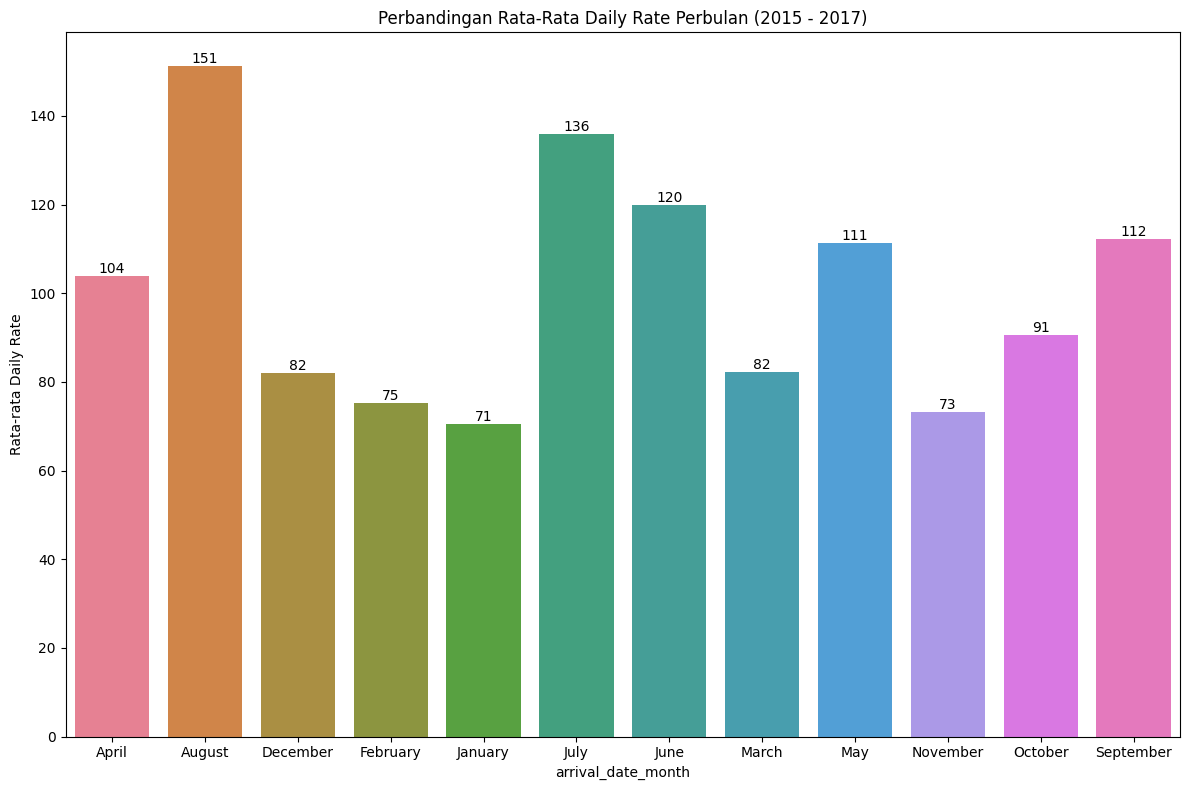

In [41]:
# Melihat perbandingan rata-rata average daily rate perbulan dari 2015-2017

plt.figure(figsize=(12, 8))

counts = (
    df_hotel_demand_bookings.groupby('arrival_date_month')['adr']
      .mean()
      .reset_index()
      .rename(columns={'adr':'avg_adr'})
)

cancelation_rate_by_reservation_status_barplot = sns.barplot(
    data=counts, x='arrival_date_month', y='avg_adr', hue='arrival_date_month'
  )

for container in cancelation_rate_by_reservation_status_barplot.containers:
    cancelation_rate_by_reservation_status_barplot.bar_label(container, fmt='%.0f')

plt.title('Perbandingan Rata-Rata Daily Rate Perbulan (2015 - 2017)')
plt.ylabel('Rata-rata Daily Rate')
plt.tight_layout()
plt.show()

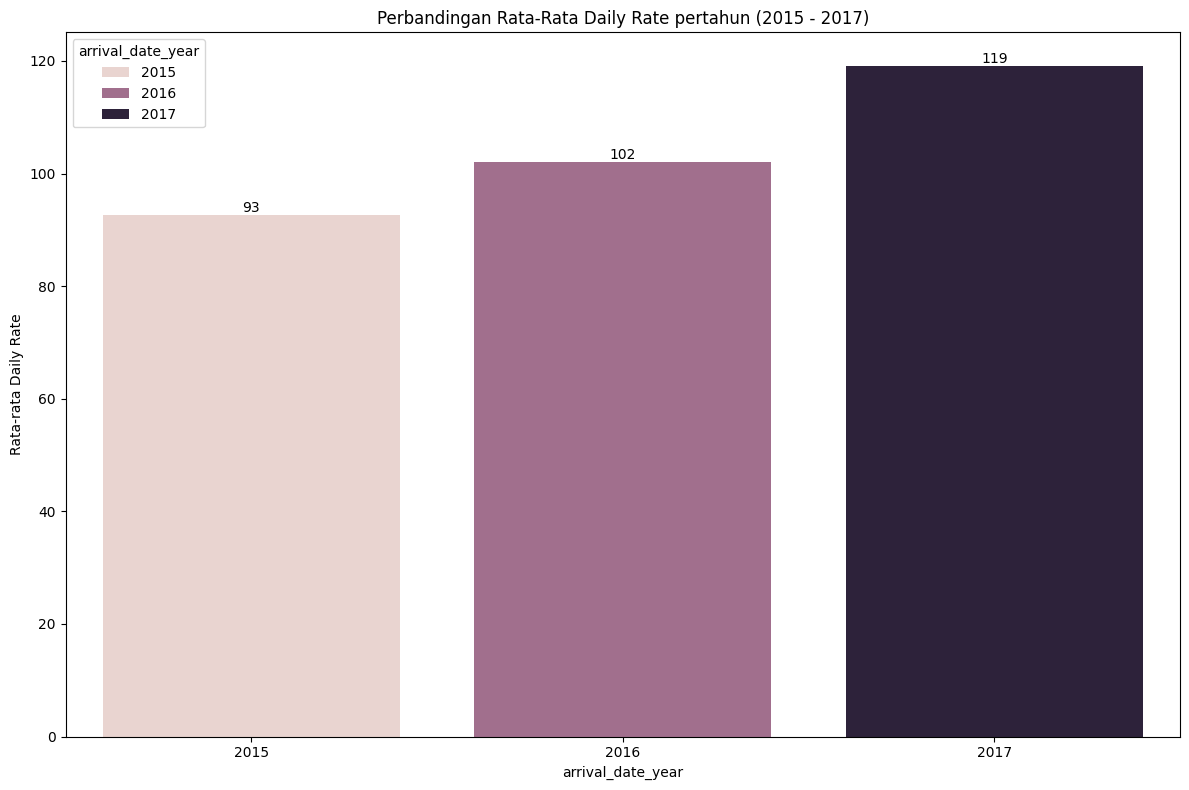

In [42]:
# Melihat perbandingan rata-rata average daily rate pertahun dari 2015-2017

plt.figure(figsize=(12, 8))

counts = (
    df_hotel_demand_bookings.groupby('arrival_date_year')['adr']
      .mean()
      .reset_index()
      .rename(columns={'adr':'avg_adr'})
)

cancelation_rate_by_reservation_status_barplot = sns.barplot(
    data=counts, x='arrival_date_year', y='avg_adr', hue='arrival_date_year'
  )

for container in cancelation_rate_by_reservation_status_barplot.containers:
    cancelation_rate_by_reservation_status_barplot.bar_label(container, fmt='%.0f')

plt.title('Perbandingan Rata-Rata Daily Rate pertahun (2015 - 2017)')
plt.ylabel('Rata-rata Daily Rate')
plt.tight_layout()
plt.show()

MACHINE LEARNING

In [43]:
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler, MinMaxScaler, OrdinalEncoder
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV,StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression


In [44]:
new_df = df_hotel_demand_bookings.copy()
new_df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,C,3,No Deposit,0,Transient,0.000e+00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,C,4,No Deposit,0,Transient,0.000e+00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,C,0,No Deposit,0,Transient,7.500e+01,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,A,0,No Deposit,0,Transient,7.500e+01,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,A,0,No Deposit,0,Transient,9.800e+01,0,1,Check-Out,2015-07-03


In [45]:
categorical_cols = df_hotel_demand_bookings.select_dtypes(include=['category', 'object']).columns.tolist()
print(categorical_cols)

['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'reservation_status']


In [47]:
object_pipeline = Pipeline(
    steps = [('encode', ce.BinaryEncoder())]
)
 #sparse_output=False, handle_unknown='ignore'
numerical_pipeline = Pipeline(
    steps = [
        ('scaling', RobustScaler()), ]
)

transformer = ColumnTransformer([
    ('cat_preprocessing', object_pipeline, categorical_cols),
    ('num_preprocessing', numerical_pipeline, num_cols_names)
], remainder= 'passthrough')

    

In [48]:
X = new_df.drop(['is_canceled', 'reservation_status_date'], axis=1)
y = new_df['is_canceled']

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)

In [50]:
knn = KNeighborsClassifier()
logreg = LogisticRegression(random_state= 20)
rf = RandomForestClassifier(random_state= 20)
dt = DecisionTreeClassifier(random_state= 20)
ab = AdaBoostClassifier(random_state= 20)
gb = GradientBoostingClassifier(random_state= 20)

pipeline = Pipeline([
    ('preprocess', transformer),
    ('Model', knn)
])
skfold= StratifiedKFold(n_splits=10, shuffle= True, random_state= 20)
hyperparams= {
    'Model' : [knn, logreg, rf, dt, ab, gb]
}

search_model = GridSearchCV(pipeline, param_grid= hyperparams, cv= skfold, scoring= 'recall', n_jobs= -1, error_score="raise")

In [51]:
pipeline

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_preprocessing',
                                                  Pipeline(steps=[('encode',
                                                                   BinaryEncoder())]),
                                                  ['hotel',
                                                   'arrival_date_month', 'meal',
                                                   'country', 'market_segment',
                                                   'distribution_channel',
                                                   'reserved_room_type',
                                                   'assigned_room_type',
                                                   'deposit_type',
                                                   'customer_type',
                                                   'reservation_status']),
                                                 ('num_preproces...
                                                  Pipeline(steps=[('scaling',
                                                                   RobustScaler())]),
                                                  ['lead_time',
                                                   'stays_in_weekend_nights',
                                                   'stays_in_week_nights',
                                                   'adults', 'children',
                                                   'babies',
                                                   'is_repeated_guest',
                                                   'previous_cancellations',
                                                   'previous_bookings_not_canceled',
                                                   'booking_changes',
                                                   'days_in_waiting_list',
                                                   'adr',
                                                   'required_car_parking_spaces',
                                                   'total_of_special_requests'])])),
                ('Model', KNeighborsClassifier())])

In [52]:
search_model.fit(X_train, y_train)
print(search_model.best_score_)
print(search_model.best_params_)
pd.DataFrame(search_model.cv_results_).sort_values(by= 'rank_test_score').set_index('param_Model').drop('params', axis= True)

1.0
{'Model': RandomForestClassifier(random_state=20)}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
param_Model,,,,,,,,,,,,,,,,,
RandomForestClassifier(random_state=20),1.937e+01,9.425e-01,3.704e-01,7.913e-02,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,0.000e+00,1
DecisionTreeClassifier(random_state=20),4.237e+00,5.791e-01,3.201e-01,9.512e-02,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,0.000e+00,1
AdaBoostClassifier(random_state=20),4.057e+00,3.243e-01,2.958e-01,4.486e-02,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,0.000e+00,1
GradientBoostingClassifier(random_state=20),1.008e+01,1.175e+00,7.050e-02,1.277e-02,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,0.000e+00,1
LogisticRegression(random_state=20),8.351e+00,6.569e-01,2.861e-01,7.270e-02,9.995e-01,9.979e-01,1.000e+00,9.974e-01,9.984e-01,9.990e-01,9.969e-01,9.990e-01,9.974e-01,9.979e-01,9.983e-01,9.591e-04,5
KNeighborsClassifier(),3.885e+00,2.350e-01,1.216e+01,2.763e-01,8.661e-01,8.609e-01,8.708e-01,8.619e-01,8.556e-01,8.651e-01,8.660e-01,8.524e-01,8.598e-01,8.723e-01,8.631e-01,5.940e-03,6
